In [1]:
import os

import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pandas as pd
import torch
from loguru import logger
from omegaconf import OmegaConf

from rocketshp import config
from rocketshp.data.atlas import ATLASDataModule
from rocketshp.modeling.architectures import RocketSHPModel
from rocketshp.trajectory import display_trajectory

plt.rcParams.update(
    {
        "axes.prop_cycle": "cycler('color', ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9'])",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.size": 16,
        "figure.autolayout": False,
        "savefig.bbox": "tight",
        "savefig.dpi": 300,
        "svg.fonttype": "none",
    }
)

In [2]:
# config_file = "../configs/default_config.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split/model-epoch=14-train_loss=0.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=02-train_loss=2.68.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=07-train_loss=2.66.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_sqformer/model-epoch=15-train_loss=13.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss/model-epoch=02-train_loss=0.83.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss.2/model-epoch=17-train_loss=0.28.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/revert_loss/model-epoch=17-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/retesting_old/model-epoch=02-train_loss=0.69.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/temperature_atlas/model-epoch=10-train_loss=0.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_alpha1_dyncorr_alpha3/model-epoch=05-train_loss=1.03.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_alpha1_dyncorr_alpha5/model-epoch=05-train_loss=1.00.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/grad_norm_alpha0.12_lr1e-5/model-epoch=19-train_loss=0.55.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/seq_feats_only/model-epoch=18-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/atlas_prequantized/model-epoch=03-train_loss=0.70.pt.ckpt"

# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/mdcath_temp_2/model-epoch=16-train_loss=0.30.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/new_predictions_local/model-epoch=05-val_loss=10.18.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_0/model-epoch=18-val_loss=2.78.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl/model-epoch=00-val_loss=36.86.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl/model-epoch=02-val_loss=37.17.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl_reweighted/model-epoch=11-val_loss=35.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/test_kl/model-epoch=01-val_loss=2.18.pt.ckpt"

# config_file = "/mnt/home/ssledzieski/Projects/rocketshp/configs/rocketshp_pretrained_20250215_v0.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/huggingface/checkpoints/rocketshp_pretrained_20250215_v0.ckpt"  # *****

# config_file = "/mnt/home/ssledzieski/Projects/rocketshp/configs/seqonly_config.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl_seqonly/model-epoch=30-val_loss=2.18.pt.ckpt"

# config_file = "/mnt/home/ssledzieski/Projects/rocketshp/configs/20250426_cadist_fixed.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_sqloss/model-epoch=23-val_loss=0.71.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_sqloss/model-epoch=43-val_loss=0.70.pt.ckpt"

# config_file = "/mnt/home/ssledzieski/Projects/rocketshp/configs/20250427_large.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/big_model/model-epoch=50-val_loss=1.00.pt.ckpt"

config_file = "/mnt/home/ssledzieski/Projects/rocketshp/configs/20250430_large_seq.yml"
checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/full_seq_model/model-epoch=13-val_loss=1.18.pt.ckpt"


PARAMS = config.DEFAULT_PARAMETERS
PARAMS.update(OmegaConf.load(config_file))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
adl = ATLASDataModule(
    config.PROCESSED_DATA_DIR / "atlas/atlas_processed.h5",
    seq_features=True,
    struct_features=True,
    batch_size=8,
    crop_size=2048,
    num_workers=PARAMS.num_data_workers,
    train_pct=PARAMS.train_pct,
    val_pct=PARAMS.val_pct,
    random_seed=PARAMS.random_seed,
    struct_stage=PARAMS.struct_stage,
)
adl.setup("train")
ads = adl.dataset
logger.info(
    f"{len(adl.dataset)}, {len(adl.train_data)}, {len(adl.val_data)}, {len(adl.test_data)}"
)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/pretrained.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/s

2025-05-02 09:54:12.091 | INFO     | __main__:<module>:15 - 4167, 3360, 396, 411


In [4]:
# model = RocketSHPModel.load_from_checkpoint("latest")
model = RocketSHPModel.load_from_checkpoint(checkpoint_file, strict=False)
model = model.to(device)
model = model.eval()

In [5]:
from scipy.stats import pearsonr, spearmanr

### by key ###


def get_idx_name(name):
    return adl.dataset.samples.index(name)


# key = "1tzw_A/R2"
# feats, labels = adl.dataset[get_idx_name(key)]
##############

### by index ###
# DATA_SUBSET = adl.test_data
DATA_SUBSET = adl.val_data
# DATA_SUBSET = adl.train_data

# SAMPLE_I = 35
SAMPLE_I = 70  # *** 1TZW
# SAMPLE_I = 15 # validation
# SAMPLE_I = 84 # validation
# SAMPLE_I = 100 # validation
# SAMPLE_I = 192 # validation
# SAMPLE_I = 300 # validation
# SAMPLE_I = 392

feats, labels = DATA_SUBSET[SAMPLE_I]
key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
##############

pdb_code, rep = key.split("/")
pdb_code_save = pdb_code + "_seqOnly"
logger.info(f"Key: {key}")
logger.info(f"Sequence length: {len(labels['rmsf'])}")


def normalize(x):
    return (x - x.mean()) / x.std()


with torch.no_grad():
    both_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})
    # feats["struct_feats"] = torch.zeros_like(feats["struct_feats"])
    # seqonly_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})

2025-05-02 09:54:15.444 | INFO     | __main__:<module>:34 - Key: 1tzw_A/R2
2025-05-02 09:54:15.446 | INFO     | __main__:<module>:35 - Sequence length: 142


In [6]:
dyna1_path = (
    f"/mnt/home/ssledzieski/GitHub/Dyna-1/rshp_results/{pdb_code}/{pdb_code}-Dyna1.csv"
)
dyna1_df = pd.read_csv(dyna1_path)
dyna1_result = dyna1_df.iloc[:, 2].values
sequence = "".join(dyna1_df.iloc[:, 1].values)
# logger.info(sequence)

In [7]:
from rocketshp.trajectory import compute_generalized_correlation_lmi, compute_rmsf

bioemu_path = f"/mnt/home/ssledzieski/GitHub/bioemu/rshp_results_100/{pdb_code}_100"
bioemu_traj = md.load(f"{bioemu_path}/samples.xtc", top=f"{bioemu_path}/topology.pdb")
bioemu_rmsf = compute_rmsf(bioemu_traj)
if os.path.exists(f"{bioemu_path}/gcc_lmi.npy"):
    bioemu_gcc_lmi = np.load(f"{bioemu_path}/gcc_lmi.npy")
else:
    bioemu_gcc_lmi = compute_generalized_correlation_lmi(
        f"{bioemu_path}/topology.pdb", f"{bioemu_path}/samples.xtc"
    )

# bioemu_path = f"/mnt/home/ssledzieski/GitHub/bioemu/rshp_results/{pdb_code}_100"
# bioemu_traj = md.load(f"{bioemu_path}/samples.xtc", top=f"{bioemu_path}/topology.pdb")
# bioemu_rmsf_100 = compute_rmsf(bioemu_traj)

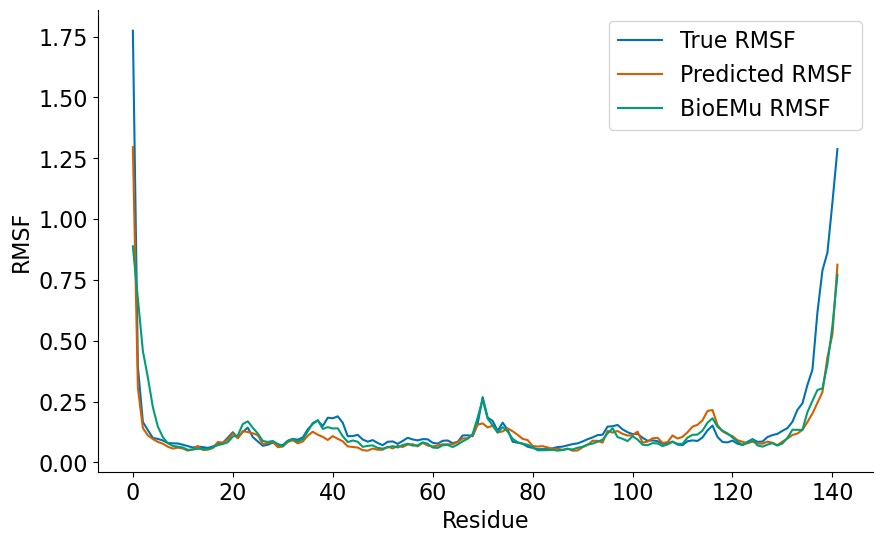

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(labels["rmsf"], label="True RMSF")
plt.plot(both_result["rmsf"].detach().cpu().numpy().squeeze(), label="Predicted RMSF")
# plt.plot(dyna1_result, label="Dyna-1 RMSF")
plt.plot(bioemu_rmsf, label="BioEMu RMSF")
# plt.plot(bioemu_rmsf_100, label="BioEMu RMSF 100")
plt.ylabel("RMSF")
plt.xlabel("Residue")
# plt.title(f"Protein: {key}")
plt.legend()
# plt.savefig(
# config.FIGURES_DIR / f"{pdb_code_save}_rmsf_comparison.svg",
# )
plt.show()

In [9]:
spearman = spearmanr(
    labels["rmsf"], both_result["rmsf"].detach().cpu().numpy().squeeze()
)
pearson = pearsonr(labels["rmsf"], both_result["rmsf"].detach().cpu().numpy().squeeze())
mse = (
    (labels["rmsf"] - both_result["rmsf"].detach().cpu().numpy().squeeze()) ** 2
).mean()

logger.info(f"Protein: {key}")
logger.info(f"Spearman: {spearman}")
logger.info(f"Pearson: {pearson}")
logger.info(f"MSE: {mse}")

2025-05-02 09:54:26.062 | INFO     | __main__:<module>:9 - Protein: 1tzw_A/R2
2025-05-02 09:54:26.063 | INFO     | __main__:<module>:10 - Spearman: SignificanceResult(statistic=0.7244206198356633, pvalue=2.2267793764184168e-24)
2025-05-02 09:54:26.063 | INFO     | __main__:<module>:11 - Pearson: PearsonRResult(statistic=0.94984853, pvalue=1.4792163560309942e-72)
2025-05-02 09:54:26.064 | INFO     | __main__:<module>:12 - MSE: 0.010818651877343655


In [13]:
logger.info(
    str(config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc")
)
logger.info(str(config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb"))
traj = md.load_xtc(
    config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",
    top=config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb",
)
# view = display_trajectory(traj)
view = display_trajectory(
    traj,
    bfactor=both_result["rmsf"].detach().cpu().numpy().squeeze(),
    coloring="bfactor",
    normalize=True,
    RMAX=0.3,
)
# view = display_trajectory(traj[::10], bfactor=labels["rmsf"].squeeze(), coloring="bfactor", normalize=True, RMAX=0.3)
# view = display_trajectory(traj[::100], coloring="residueindex")
view

2025-05-02 09:54:39.993 | INFO     | __main__:<module>:1 - /mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/1t/1tzw_A_prod_R2_fit.xtc
2025-05-02 09:54:39.995 | INFO     | __main__:<module>:2 - /mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/1t/1tzw_A.pdb


NGLWidget(max_frame=10000)

In [11]:
# import numpy as np

# subsample_rmsf = []
# for _ in range(50):
#     start = np.random.randint(0, traj.n_frames // 2)
#     duration = np.random.randint(1, traj.n_frames // 2 - start)
#     stride = 1
#     t_sub = traj[start : start + duration : stride]
#     sample = md.rmsf(t_sub, t_sub, 0, atom_indices=traj.top.select("name CA"))
#     subsample_rmsf.append(sample)

# subsample_rmsf = np.stack(subsample_rmsf)
# import matplotlib.pyplot as plt

# plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.T, alpha=0.2)
# plt.xlabel("Residue")
# plt.ylabel("RMSF")
# plt.show()

# plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.mean(axis=0), label="mean")
# plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0), label="std")
# plt.plot(
#     np.arange(subsample_rmsf.shape[1]),
#     subsample_rmsf.std(axis=0) / (subsample_rmsf.mean(axis=0) ** 2),
#     label="std/mean**2",
# )

# plt.legend()
# plt.show()

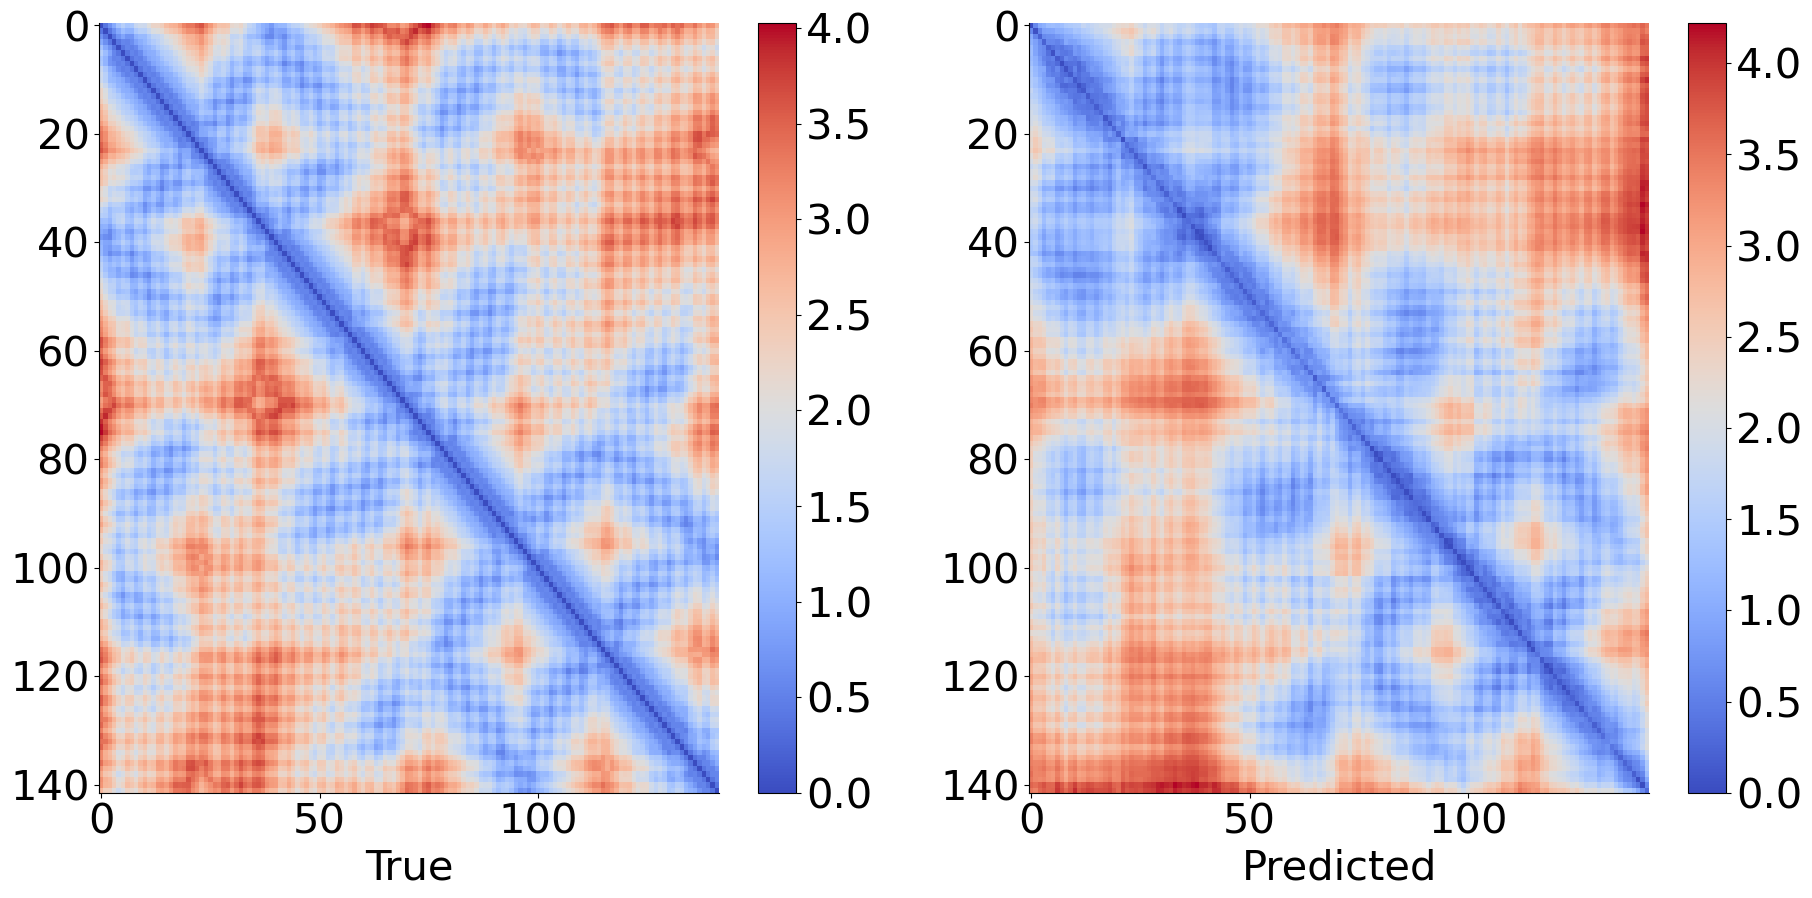

In [12]:
# Autocorrelation
# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
squared_label_type = "ca_dist"

true_sqform = labels[squared_label_type].squeeze().T
predicted_sqform = both_result[squared_label_type].cpu().squeeze().T

# increase font size
with plt.rc_context({"font.size": 30}):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    im1 = axes[0].imshow(true_sqform, aspect="auto", cmap="coolwarm")
    axes[0].set_xlabel("True")
    im2 = axes[1].imshow(predicted_sqform, aspect="auto", cmap="coolwarm")
    axes[1].set_xlabel("Predicted")

    # Add space for the colorbar
    plt.colorbar(im1)
    plt.colorbar(im2)

    # Create a position for the colorbar that doesn't overlap with the plots
    # Located at the rightmost position
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    # Add the colorbar using the first image
    # fig.colorbar(im1, cax=cbar_ax)

    # plt.savefig(
    # config.FIGURES_DIR / f"{pdb_code_save}_ca_dist_comparison.svg",
    # bbox_inches="tight",
    # )
    plt.show()

In [27]:
# # Autocorrelation
# # fig, ax = plt.subplots(1, 2, figsize=(15, 10))
# squared_label_type = "autocorr"

# true_sqform = labels[squared_label_type].squeeze().T
# predicted_sqform = both_result[squared_label_type].cpu().squeeze().T

# # ax[0].imshow(true_sqform)
# #
# # image = ax[1].imshow(predicted_sqform)
# # ax[1].set_xlabel("Predicted")
# # plt.colorbar(image)

# # increase font size
# with plt.rc_context({"font.size": 30}):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
#     im1 = axes[0].imshow(1 - true_sqform, vmin=0, vmax=1, aspect="auto", cmap="coolwarm")
#     axes[0].set_xlabel("True")
#     im2 = axes[1].imshow(
#         1 - predicted_sqform, vmin=0, vmax=1, aspect="auto", cmap="coolwarm"
#     )
#     axes[1].set_xlabel("Predicted")

#     # add space for colour bar
#     fig.subplots_adjust(right=0.85)
#     cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
#     cbar = fig.colorbar(im2, cax=cbar_ax)
#     cbar.ax.set_ylabel("Autocorrelation of Distances", rotation=-90, va="bottom")

#     # plt.savefig(
#         # config.FIGURES_DIR / f"{pdb_code_save}_autocorr_comparison.svg",
#         # bbox_inches="tight",
#     # )
#     plt.show()

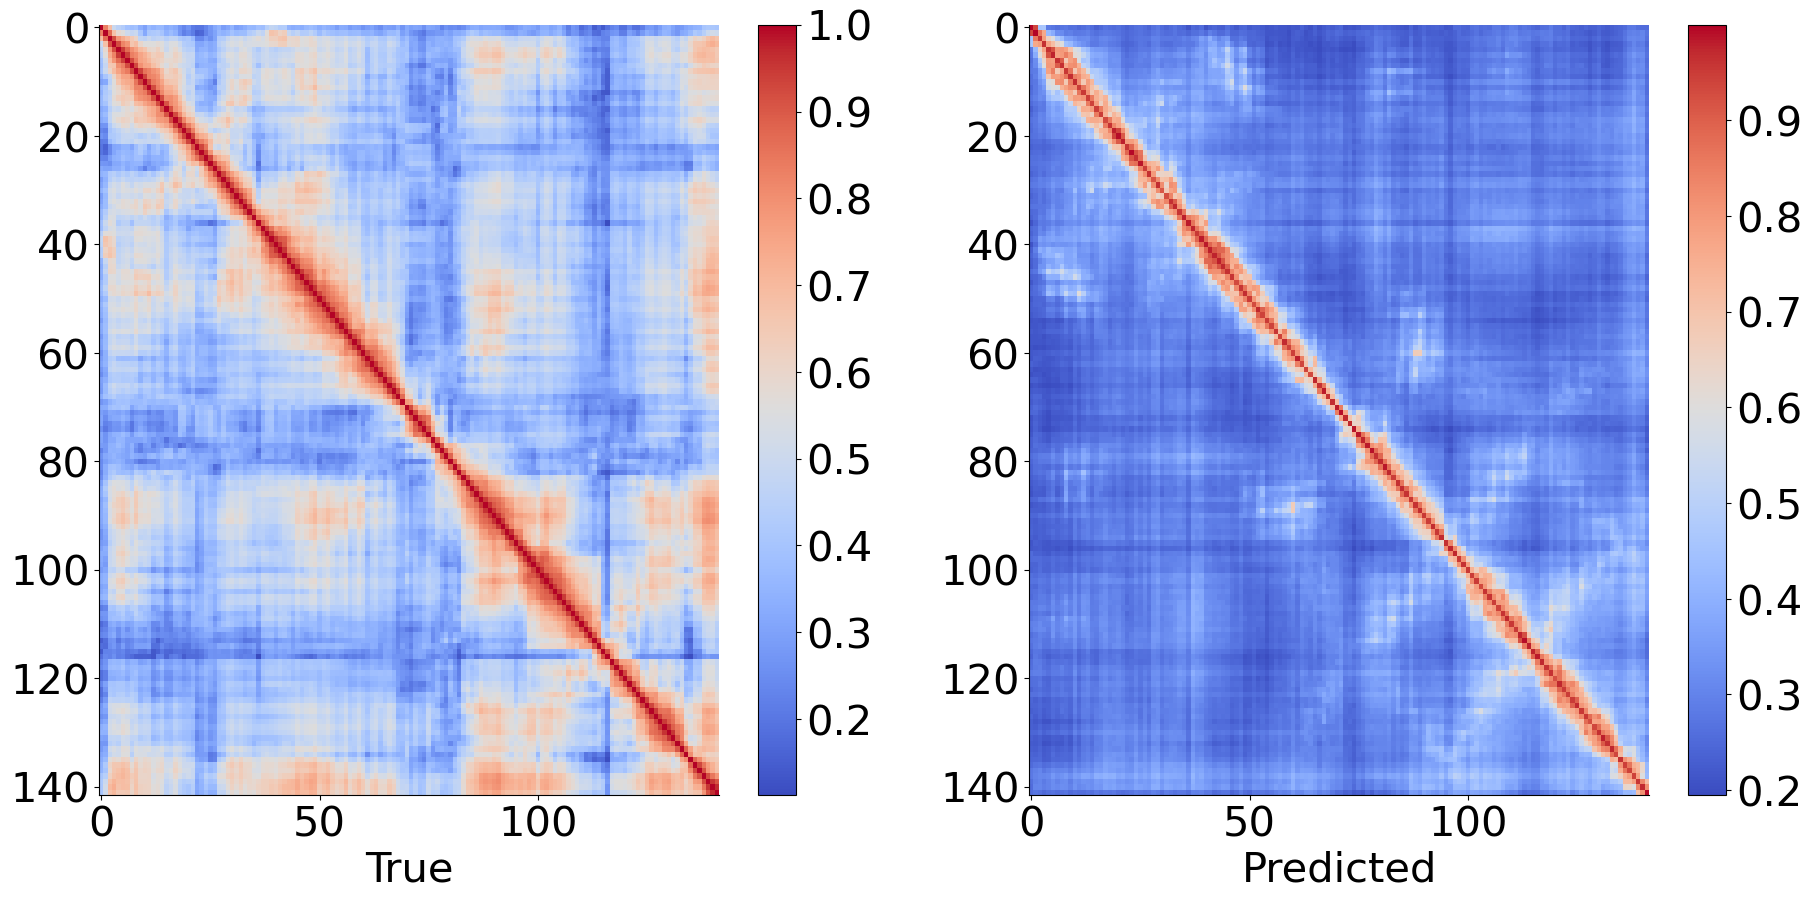

In [28]:
# GCC LMI
# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
squared_label_type = "gcc_lmi"

true_sqform = labels[squared_label_type].squeeze().T
predicted_sqform = both_result[squared_label_type].cpu().squeeze().T

# ax[0].imshow(true_sqform)
#
# image = ax[1].imshow(predicted_sqform)
# ax[1].set_xlabel("Predicted")
# plt.colorbar(image)

# increase font size
with plt.rc_context({"font.size": 30}):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    im1 = axes[0].imshow(true_sqform, aspect="auto", cmap="coolwarm")
    axes[0].set_xlabel("True")
    im2 = axes[1].imshow(predicted_sqform, aspect="auto", cmap="coolwarm")
    axes[1].set_xlabel("Predicted")

    plt.colorbar(im1)
    plt.colorbar(im2)

    # plt.savefig(
    # config.FIGURES_DIR / f"{pdb_code_save}_autocorr_comparison.svg",
    # bbox_inches="tight",
    # )
    plt.show()

2025-04-27 22:15:03.088 | INFO     | __main__:<module>:32 - Graph Diffusion Distance (Random): 0.1340
2025-04-27 22:15:03.088 | INFO     | __main__:<module>:33 - Graph Diffusion Distance (Identity): 0.7664
2025-04-27 22:15:03.089 | INFO     | __main__:<module>:34 - Graph Diffusion Distance (Predicted): 0.2265
2025-04-27 22:15:03.089 | INFO     | __main__:<module>:35 - Graph Diffusion Distance (BioEmu): 0.2839


2025-04-27 22:15:04.646 | INFO     | __main__:<module>:49 - Ipsen-Mikhailov Distance (Random): 1.4189
2025-04-27 22:15:04.647 | INFO     | __main__:<module>:50 - Ipsen-Mikhailov Distance (Predicted): 3.0033
2025-04-27 22:15:04.649 | INFO     | __main__:<module>:51 - Ipsen-Mikhailov Distance (BioEmu): 3.1476


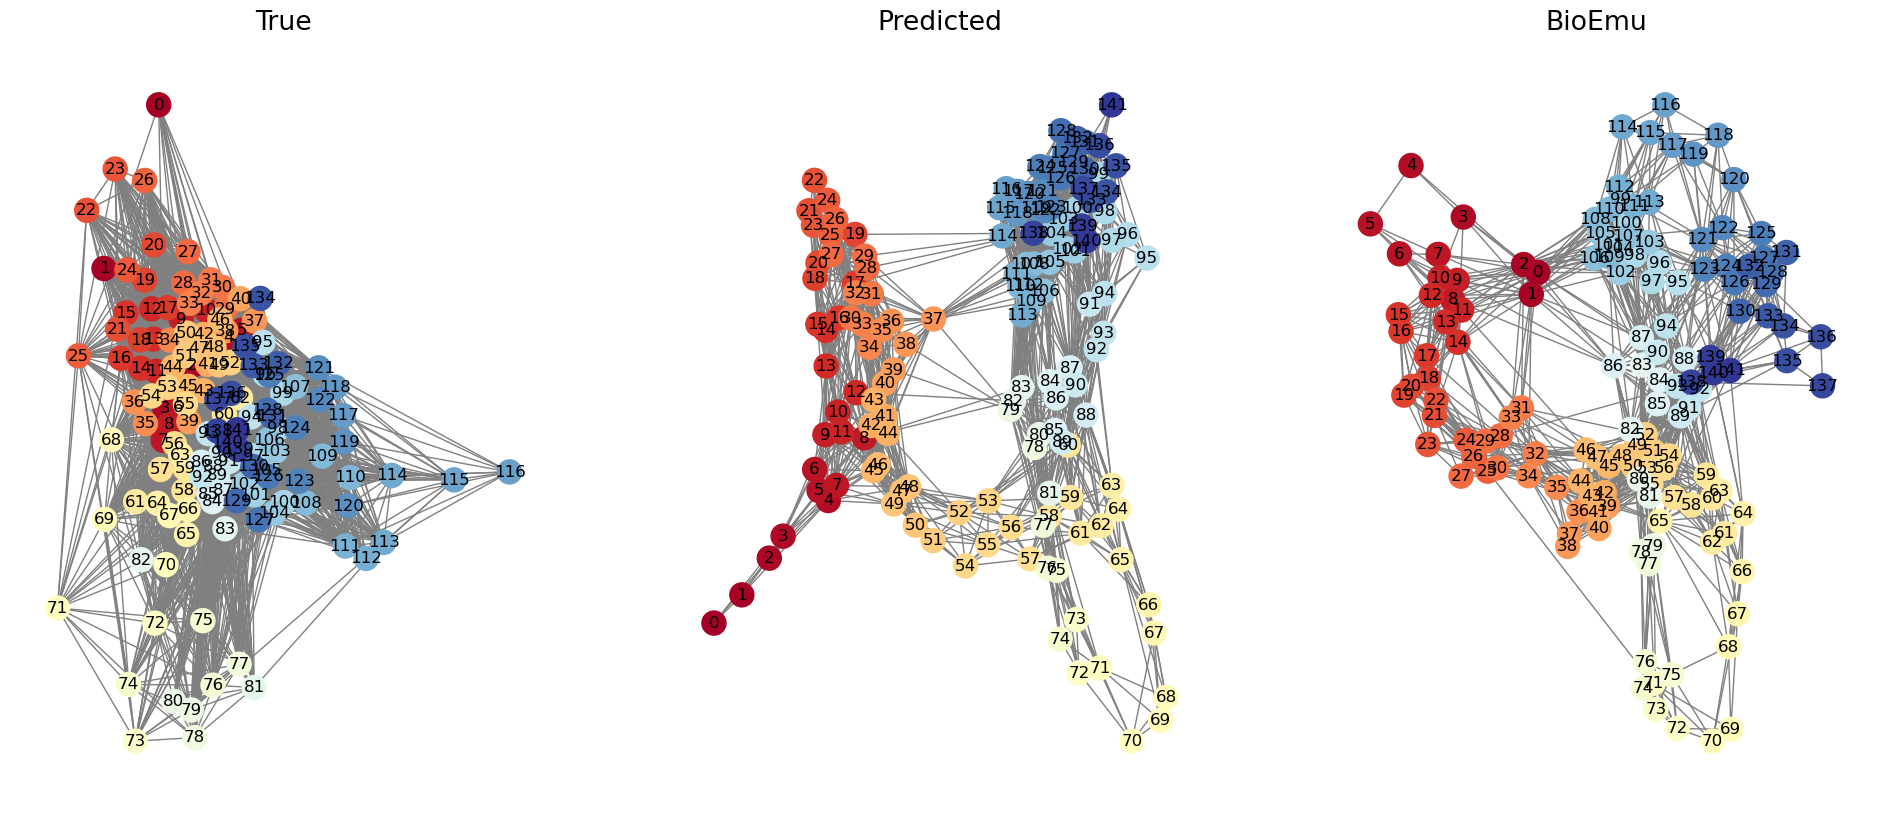

In [29]:
from rocketshp.metrics import graph_diffusion_distance, ipsen_mikhailov_distance
from rocketshp.network import pairwise_correlation_to_network

beta = 0.001
true_net = true_sqform.numpy()
predicted_net = predicted_sqform.numpy()
bioemu_net = bioemu_gcc_lmi
random_net = np.random.rand(*true_net.shape)
eye_net = np.eye(*true_net.shape)

gd_dist = graph_diffusion_distance(true_net, predicted_net, beta=beta)
gd_dist_bioemu = graph_diffusion_distance(true_net, bioemu_net, beta=beta)
gd_dist_random = graph_diffusion_distance(true_net, random_net, beta=beta)
gd_dist_eye = graph_diffusion_distance(true_net, eye_net, beta=beta)

logger.info(f"Graph Diffusion Distance (Random): {gd_dist_random:.4f}")
logger.info(f"Graph Diffusion Distance (Identity): {gd_dist_eye:.4f}")
logger.info(f"Graph Diffusion Distance (Predicted): {gd_dist:.4f}")
logger.info(f"Graph Diffusion Distance (BioEmu): {gd_dist_bioemu:.4f}")

im_dist = ipsen_mikhailov_distance(
    true_net,
    predicted_net,
)
im_dist_bioemu = ipsen_mikhailov_distance(
    true_net,
    bioemu_net,
)
im_dist_random = ipsen_mikhailov_distance(
    true_net,
    random_net,
)
logger.info(f"Ipsen-Mikhailov Distance (Random): {im_dist_random:.4f}")
logger.info(f"Ipsen-Mikhailov Distance (Predicted): {im_dist:.4f}")
logger.info(f"Ipsen-Mikhailov Distance (BioEmu): {im_dist_bioemu:.4f}")


thresh = 0.4
fig, ax = plt.subplots(1, 3, figsize=(24, 10))
pairwise_correlation_to_network(
    true_sqform.numpy(),
    thresh=thresh,
    ax=ax[0],
    title="True",
    seed=42,
)
pairwise_correlation_to_network(
    predicted_sqform.numpy(),
    thresh=thresh,
    ax=ax[1],
    title="Predicted",
    seed=42,
)
pairwise_correlation_to_network(
    bioemu_gcc_lmi,
    thresh=thresh,
    ax=ax[2],
    title="BioEmu",
    seed=42,
)

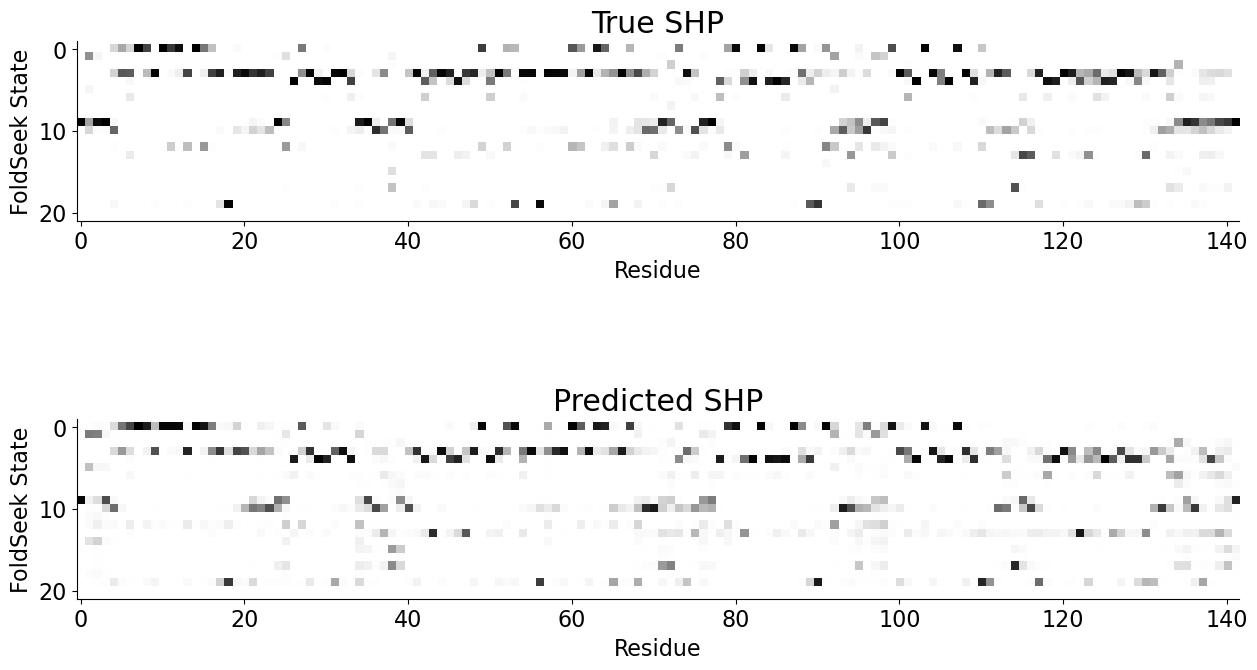

In [10]:
# Foldseek Structure Heterogeneity Profile
fig, ax = plt.subplots(2, 1, figsize=(15, 9))
from torch.nn.functional import softmax

true_shp = labels["shp"].squeeze().T
predicted_shp = both_result["shp"].cpu().squeeze().T

with plt.rc_context({"font.size": 18}):
    ax[0].imshow(true_shp, cmap="binary")
    ax[0].set_xlabel("True")
    ax[0].set_ylim(21, -1)
    ax[0].set_title("True SHP")
    ax[0].set_xlabel("Residue")
    ax[0].set_ylabel("FoldSeek State")

    ax[1].imshow(softmax(predicted_shp, dim=0), cmap="binary")
    # ax[1].imshow(predicted_shp, cmap="binary")
    ax[1].set_title("Predicted SHP")
    ax[1].set_ylabel("FoldSeek State")
    ax[1].set_xlabel("Residue")
    ax[1].set_ylim(21, -1)

    # plt.savefig(
    # config.FIGURES_DIR / f"{pdb_code_save}_shp_comparison.svg",
    # bbox_inches="tight",
    # )
plt.show()

1.7737343 -inf tensor(1.7741)


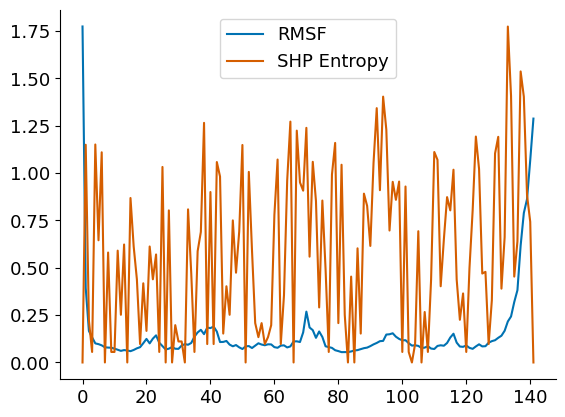

In [60]:
from scipy.stats import entropy

ent = entropy(true_shp)
p_ent = entropy(predicted_shp)
print(ent.max(), p_ent.max(), labels["rmsf"].max())
plt.plot(labels["rmsf"], label="RMSF")
plt.plot(ent, label="SHP Entropy")
# plt.plot(p_ent, label="Predicted SHP Entropy")
plt.legend()
plt.show()

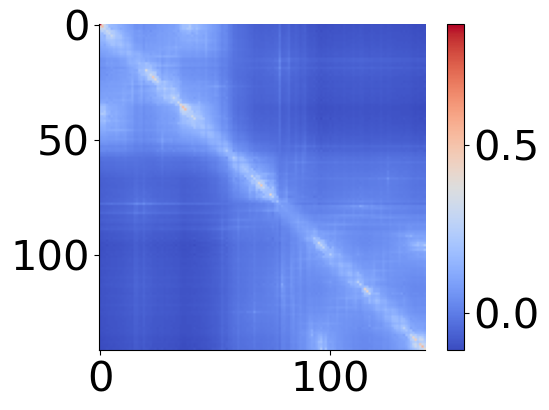

In [71]:
GNM_ROOT = (
    "/mnt/home/ssledzieski/Projects/rocketshp/data/processed/atlas/gaussian_net_models"
)
gnm_covar = f"{GNM_ROOT}/{pdb_code[:2]}/{pdb_code}_gnm.npz"
gnm_data = np.load(gnm_covar)
gnm_covar = gnm_data["covar"]
plt.imshow(gnm_covar, cmap="coolwarm")
plt.colorbar()
plt.show()

---